In [1]:

# File paths and feature names
tree_pred_path = r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\tree_season_pred.csv'
non_tree_pred_path = r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\non_tree_season_pred.csv'
ltsm_pred_path = r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\ltsm_season_pred.csv'
ltsm_seq_pred_path = r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\ltsm_seq_season_pred.csv'
past_results_path = r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\23_24_current_season_prediction_tracker.csv'
votes_data_path = r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\voter_pred.csv'
linreg_team_data_path = r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\linreg_team_point_pred.csv'



import pandas as pd
import numpy as np

#Take out predictions with the Same value for model so we only track valuable predictions
def validate_predictions(data):
    prediction_columns = [
        'XGBoost_PREDICTION', 'Decision Tree_PREDICTION', 'Random Forest_PREDICTION', 
        'Gradient Boosting_PREDICTION', 'AdaBoost_PREDICTION', 'MLP Classifier_PREDICTION', 
        'K-Neighbors Classifier_PREDICTION', 'SVM_PREDICTION', 'SGD Classifier_PREDICTION', 
        'Ridge Classifier_PREDICTION', 'Logistic Regression_PREDICTION', 'ltsm_PREDICTION', 'ltsm_seq_PREDICTION'
    ]
    
    # Iterate over each prediction column to validate
    for col in prediction_columns:
        # Calculate the sum of predictions for each matchup within the column
        data[f'{col}_sum'] = data.groupby(['Date', 'MATCHUP_ID'])[col].transform('sum')
        
        # Identify rows where the sum of predictions is not equal to 1
        invalid_mask = data[f'{col}_sum'] != 1
        
        # Set predictions to NaN for rows where the sum is not 1
        data.loc[invalid_mask, col] = np.nan
    
    # Drop the temporary sum columns
    sum_columns = [f'{col}_sum' for col in prediction_columns]
    data = data.drop(columns=sum_columns)
    
    return data

def load_linreg_team_data(path):
    return pd.read_csv(path)


# Data Loading Functions
def load_tree_data(path):
    return pd.read_csv(path)[['Date', 'MATCHUP_ID', 'TEAM_NAME', 'XGBoost_PREDICTION', 'Decision Tree_PREDICTION', 'Random Forest_PREDICTION', 'Gradient Boosting_PREDICTION', 'AdaBoost_PREDICTION']]

def load_non_tree_data(path):
    return pd.read_csv(path)[['Date', 'MATCHUP_ID', 'TEAM_NAME', 'MLP Classifier_PREDICTION', 'K-Neighbors Classifier_PREDICTION', 'SVM_PREDICTION', 'SGD Classifier_PREDICTION', 'Ridge Classifier_PREDICTION', 'Logistic Regression_PREDICTION']]

def load_ltsm_data(path):
    ltsm_data = pd.read_csv(path)
    #ltsm_data = ltsm_data.rename(columns={'PREDICTION': 'ltsm_PREDICTION'})
    ltsm_data['Date'] = pd.to_datetime(ltsm_data['Date'])
    ltsm_data['Date'] = ltsm_data['Date'].dt.strftime('%Y-%m-%d')
    return ltsm_data[['Date', 'MATCHUP_ID', 'TEAM_NAME', 'ltsm_PREDICTION']]

def load_ltsm_seq_data(path):
    ltsm_seq_data = pd.read_csv(path)
    #ltsm_seq_data = ltsm_seq_data.rename(columns={'PREDICTION': 'ltsm_seq_PREDICTION'})
    return ltsm_seq_data[['Date', 'MATCHUP_ID', 'TEAM_NAME', 'ltsm_seq_PREDICTION']]

def load_past_results(path):
    return pd.read_csv(path)

def merge_data(tree_data, non_tree_data, ltsm_seq_data, ltsm_data):
    # Check column names
    tree_cols = set(tree_data.columns)
    non_tree_cols = set(non_tree_data.columns)
    ltsm_seq_cols = set(ltsm_seq_data.columns)
    ltsm_cols = set(ltsm_data.columns)
    common_cols = tree_cols & non_tree_cols & ltsm_seq_cols & ltsm_cols
    print(f"Common columns for merge: {common_cols}")
    
    # Check for matching data types
    for col in common_cols:
        if tree_data[col].dtype != non_tree_data[col].dtype or \
           tree_data[col].dtype != ltsm_seq_data[col].dtype or \
           tree_data[col].dtype != ltsm_data[col].dtype:
            print(f"Data type mismatch found in column: {col}")
    
    # Perform the merges and check row counts
    tree_non_tree = pd.merge(tree_data, non_tree_data, on=list(common_cols), how='left')
    print(f"Rows after tree and non-tree merge: {tree_non_tree.shape[0]}")
    
    tree_non_tree_ltsm_seq = pd.merge(tree_non_tree, ltsm_seq_data, on=list(common_cols), how='left')
    print(f"Rows after adding ltsm_seq data: {tree_non_tree_ltsm_seq.shape[0]}")
    
    all_data = pd.merge(tree_non_tree_ltsm_seq, ltsm_data, on=list(common_cols), how='left')
    print(f"Rows after adding ltsm data: {all_data.shape[0]}")

    # Correct the renaming for linreg_team_data_home
    linreg_team_data_home = linreg_team_data[['PTS_HOME', 'TEAM_NAME_HOME', 'TEAM_ID_HOME', 'MATCHUP_ID', 'Date', 'HOME_WIN']]
    linreg_team_data_home = linreg_team_data_home.rename(columns={
        'PTS_HOME': 'linreg_team_point_PREDICTION', 
        'TEAM_NAME_HOME': 'TEAM_NAME', 
        'TEAM_ID_HOME': 'TEAM_ID', 
        'HOME_WIN': 'linreg_wl_PREDICTION'
    })

    # Correct the merging operation
    #all_data_lr = pd.merge(all_data, linreg_team_data_home, on=list(common_cols), how='left')

    # Correct the renaming for linreg_team_data_away
    linreg_team_data_away = linreg_team_data[['PTS_AWAY', 'TEAM_NAME_AWAY', 'TEAM_ID_AWAY', 'MATCHUP_ID', 'Date', 'AWAY_WIN']]
    linreg_team_data_away = linreg_team_data_away.rename(columns={
        'PTS_AWAY': 'linreg_team_point_PREDICTION', 
        'TEAM_NAME_AWAY': 'TEAM_NAME', 
        'TEAM_ID_AWAY': 'TEAM_ID', 
        'AWAY_WIN': 'linreg_wl_PREDICTION'
    })

    #concatenate the two dataframes
    linreg_team_data_union = pd.concat([linreg_team_data_home, linreg_team_data_away])

    # Correct the merging operation
    all_data_lr_two = pd.merge(all_data, linreg_team_data_union, on=list(common_cols), how='left')



    # Check for NaN values in key columns
    for col in common_cols:
        nan_count = all_data_lr_two[col].isna().sum()
        if nan_count > 0:
            print(f"NaN values found in column: {col} - {nan_count} NaNs")
    
    # Validate predictions before merging with votes
    validated_data = validate_predictions(all_data_lr_two)
    
    # Now merge with votes data and check final row count
    all_data_with_votes = pd.merge(validated_data, aggregated_votes, on=list(common_cols), how='left')
    print(f"Rows after merging with votes data: {all_data_with_votes.shape[0]}")
    
    return all_data_with_votes


votes_data = pd.read_csv(votes_data_path)
# Aggregate votes by Date, MATCHUP_ID, and TEAM_NAME
aggregated_votes = votes_data.groupby(['Date', 'MATCHUP_ID', 'TEAM_NAME']).sum().reset_index().rename(columns={'Votes': 'voter_predictions'})

tree_data = load_tree_data(tree_pred_path)
non_tree_data = load_non_tree_data(non_tree_pred_path)
ltsm_data = load_ltsm_data(ltsm_pred_path)
ltsm_seq_data = load_ltsm_seq_data(ltsm_seq_pred_path)
linreg_team_data = load_linreg_team_data(linreg_team_data_path)

# Merge all data
all_data = merge_data(tree_data, non_tree_data, ltsm_data, ltsm_seq_data)
print(all_data.columns)

#merge with past results
past_results = load_past_results(past_results_path)
#rename GAME_DATE to Date
past_results = past_results.rename(columns={'GAME_DATE': 'Date'})
all_data = pd.merge(all_data, past_results, on=['Date', 'MATCHUP_ID', 'TEAM_NAME'], how='left')

print(f"Final data shape: {all_data.shape}")
#print(all_data.isna().sum())
#print(all_data.head())
#print(all_data.columns)

Common columns for merge: {'TEAM_NAME', 'Date', 'MATCHUP_ID'}
Rows after tree and non-tree merge: 558
Rows after adding ltsm_seq data: 558
Rows after adding ltsm data: 558
Rows after merging with votes data: 558
Index(['Date', 'MATCHUP_ID', 'TEAM_NAME', 'XGBoost_PREDICTION',
       'Decision Tree_PREDICTION', 'Random Forest_PREDICTION',
       'Gradient Boosting_PREDICTION', 'AdaBoost_PREDICTION',
       'MLP Classifier_PREDICTION', 'K-Neighbors Classifier_PREDICTION',
       'SVM_PREDICTION', 'SGD Classifier_PREDICTION',
       'Ridge Classifier_PREDICTION', 'Logistic Regression_PREDICTION',
       'ltsm_PREDICTION', 'ltsm_seq_PREDICTION',
       'linreg_team_point_PREDICTION', 'TEAM_ID', 'linreg_wl_PREDICTION',
       'voter_predictions'],
      dtype='object')
Final data shape: (710, 115)


In [2]:
all_data.sort_values(by='Date', inplace=True)

# Assuming 'WL_encoded' and 'linreg_wl_PREDICTION' are your actual columns that you're comparing.
# Only consider rows where 'linreg_wl_PREDICTION' is not null for calculating correctness
mask = all_data['linreg_wl_PREDICTION'].notnull()
all_data.loc[mask, 'Correct'] = np.where(all_data.loc[mask, 'WL_encoded'] == all_data.loc[mask, 'linreg_wl_PREDICTION'], 1, 0)

# Calculate the point differences only where 'linreg_team_point_PREDICTION' is not null
mask = all_data['linreg_team_point_PREDICTION'].notnull()
all_data.loc[mask, 'Point_Diff'] = abs(all_data.loc[mask, 'PTS'] - all_data.loc[mask, 'linreg_team_point_PREDICTION'])

# Calculate the cumulative MAE only on non-null Point_Diff values
all_data['Cumulative_MAE'] = all_data.loc[mask, 'Point_Diff'].expanding().mean()

# Calculate the cumulative correct sum only on non-null Correct values
all_data['Cumulative_Correct'] = all_data.loc[mask, 'Correct'].expanding().sum()

# Games predicted would also be the cumulative count of non-null predictions
all_data['Games_Predicted'] = all_data.loc[mask, 'Correct'].expanding().count()

# Calculate the cumulative correct percentage
all_data['Cumulative_Correct_Percentage'] = all_data['Cumulative_Correct'] / all_data['Games_Predicted']

# Print the relevant data
print(all_data[['Date', 'MATCHUP_ID', 'Correct', 'PTS', 'linreg_team_point_PREDICTION', 'Cumulative_MAE', 'Cumulative_Correct_Percentage']])

all_predictions_path = r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\new_season_predictions\predictions_combined.csv'
# Optionally, save to CSV
all_data.to_csv(all_predictions_path, index=False)
#^^do this for all _prediction columns and then just display the last row in the app and the accuracy columns for the scatterplot


           Date MATCHUP_ID  Correct    PTS  linreg_team_point_PREDICTION  \
0    2023-10-25     CHIOKC      NaN  124.0                           NaN   
23   2023-10-25     ATLCHA      NaN  116.0                           NaN   
22   2023-10-25     ATLCHA      NaN  110.0                           NaN   
21   2023-10-25     MINTOR      NaN   97.0                           NaN   
20   2023-10-25     SACUTA      NaN  130.0                           NaN   
..          ...        ...      ...    ...                           ...   
688  2023-12-02     CHINOP      0.0    NaN                    110.597702   
687  2023-12-02     CLEDET      0.0    NaN                    107.336876   
686  2023-12-02     CLEDET      0.0    NaN                     91.442635   
696  2023-12-02     DALOKC      0.0    NaN                    115.728073   
709  2023-12-02     ATLMIL      0.0    NaN                    121.373047   

     Cumulative_MAE  Cumulative_Correct_Percentage  
0               NaN               

In [3]:
import streamlit as st
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve


models = [
    "XGBoost", "Decision Tree", "Random Forest",
    "Gradient Boosting", "AdaBoost", "MLP Classifier",
    "K-Neighbors Classifier", "SVM", "SGD Classifier",
    "Ridge Classifier", "Logistic Regression", "ltsm",
    "ltsm_seq", "linreg_team_point", "linreg_wl"
]
accuracies = {}
mae_values = {}

for model in models:
    # Filter out NaN values for both predictions and actual results
    filtered_df = all_data.dropna(subset=['WL_encoded', f"{model}_PREDICTION"])
    # For the linear regression model, calculate MAE
    if "linreg_team_point" in model:
        mae_values[model] = mean_absolute_error(filtered_df['PTS'], filtered_df[f"{model}_PREDICTION"])
    else:
        # For classification models, calculate accuracy
        accuracies[model] = accuracy_score(filtered_df['WL_encoded'], filtered_df[f"{model}_PREDICTION"])

# Combine the accuracy and MAE dictionaries into a dataframe
accuracy_df = pd.DataFrame(list(accuracies.items()), columns=['Model', 'Accuracy'])
mae_df = pd.DataFrame(list(mae_values.items()), columns=['Model', 'MAE'])

# Merge the two dataframes on the 'Model' column
performance_df = pd.merge(accuracy_df, mae_df, on='Model', how='outer')

# If you want to display 'linreg' as 'Linear Regression' in your table
performance_df['Model'] = performance_df['Model'].replace({
    'linreg_team_point': 'Linear Regression (Team Points)',
    'linreg_wl': 'Linear Regression (Win/Loss)'
})

print(performance_df)


                              Model  Accuracy        MAE
0                           XGBoost  0.616279        NaN
1                     Decision Tree  0.610256        NaN
2                     Random Forest  0.627907        NaN
3                 Gradient Boosting  0.614458        NaN
4                          AdaBoost  0.612717        NaN
5                    MLP Classifier  0.640351        NaN
6            K-Neighbors Classifier  0.566038        NaN
7                               SVM  0.628319        NaN
8                    SGD Classifier  0.633663        NaN
9                  Ridge Classifier  0.637168        NaN
10              Logistic Regression  0.615385        NaN
11                             ltsm  0.661538        NaN
12                         ltsm_seq  0.561728        NaN
13     Linear Regression (Win/Loss)  0.620690        NaN
14  Linear Regression (Team Points)       NaN  11.156696


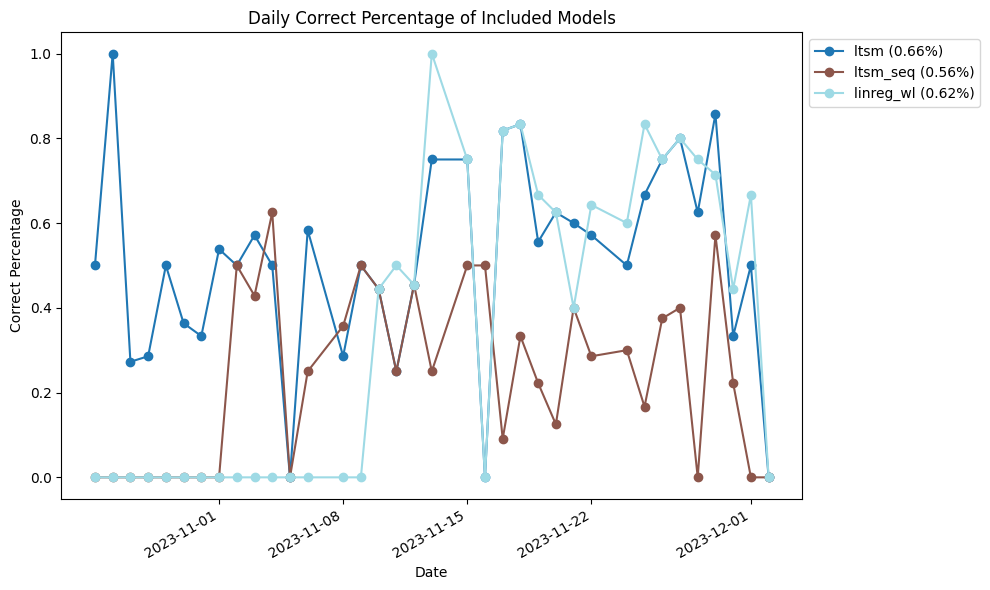

2023-12-02 11:10:18.824 
  command:

    streamlit run C:\Users\ghadf\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py [ARGUMENTS]


DeltaGenerator()

In [4]:

# Combine the accuracy and MAE dictionaries into a dataframe
accuracy_df = pd.DataFrame(list(accuracies.items()), columns=['Model', 'Accuracy'])


# Function to calculate daily correct percentage
def calculate_daily_correct_percentage(data, model):
    data['correct'] = data[f'{model}_PREDICTION'] == data['WL_encoded']
    daily_correct = data.groupby('Date')['correct'].mean().reset_index()
    daily_correct['Date'] = pd.to_datetime(daily_correct['Date'])
    return daily_correct.sort_values('Date')

included_models = ['ltsm', 'ltsm_seq', 'linreg_wl']

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Set up a color palette
colors = plt.cm.tab20(np.linspace(0, 1, len(included_models)))

# Overlay lines for each included model's daily correct percentage
for i, model in enumerate(included_models):
    daily_correct_percentage = calculate_daily_correct_percentage(all_data, model)
    # Calculate the average accuracy for the model
    avg_accuracy = accuracy_df.loc[accuracy_df['Model'] == model, 'Accuracy'].values[0]
    # Append the average accuracy to the model's name for the legend
    ax.plot(daily_correct_percentage['Date'], daily_correct_percentage['correct'], label=f"{model} ({avg_accuracy:.2f}%)", color=colors[i], marker='o')

# Formatting the plot
ax.xaxis_date()  # Interpret the x-axis values as dates
fig.autofmt_xdate()  # Auto-format the x-axis labels for date
plt.title('Daily Correct Percentage of Included Models')
plt.xlabel('Date')
plt.ylabel('Correct Percentage')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# Display the plot in Streamlit
st.pyplot(fig)